 CONEXION BASE DE DATOS, IMPORTACION Y TRANSFORMACION DE LOS DATOS

In [24]:
# IMPORTACION LIBRERIAS

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import pandas as pd
import seaborn as sns

import mysql.connector
import numpy as np
from datetime import datetime, date


In [ ]:
# CONEXION BASE DE DATOS
database_data={
    'host':'localhost',
    'database':'sprint_4',
    'user':,
    'password':'
    }
connection = mysql.connector.connect(**database_data)
cursor = connection.cursor()

In [26]:
# DEFINICION DE LA FUNCION - CREACION DATAFRAMES DESDE TABLAS
def crear_dataframes_desde_bd(cursor):
    cursor.execute("SHOW TABLES")
    nombres_tablas = [fila[0] for fila in cursor.fetchall()]

    for nombre in nombres_tablas:
        try:
            cursor.execute(f"SELECT * FROM {nombre}")
            datos = cursor.fetchall()
            columnas = [desc[0] for desc in cursor.description]
            nombre_variable = "df_" + nombre.replace('-', '_').replace(' ', '_')

            if nombre_variable[3].isdigit():
                nombre_variable = "df_" + nombre_variable[4:]

            globals()[nombre_variable] = pd.DataFrame(datos, columns=columnas)

            print(f"DataFrame {nombre_variable} creado.")

        except Exception as e:
            print(f"Error al procesar la tabla {nombre}: {e}")
    
    print(f"{len(nombres_tablas)} DataFrames creados en el espacio global.")
    print(f"Tablas procesadas: {nombres_tablas}")


In [27]:
# LLAMADA A LA FUNCION - CREACION DATAFRAMES DESDE TABLAS
crear_dataframes_desde_bd(cursor)

DataFrame df_companies creado.
DataFrame df_credit_cards creado.
DataFrame df_credit_cards_status creado.
DataFrame df_dates creado.
DataFrame df_products creado.
DataFrame df_transactions creado.
DataFrame df_transactions_products creado.
DataFrame df_users creado.
8 DataFrames creados en el espacio global.
Tablas procesadas: ['companies', 'credit_cards', 'credit_cards_status', 'dates', 'products', 'transactions', 'transactions_products', 'users']


In [28]:
try:
    connection.ping(reconnect=False)
    print("Conectado (no esperado)")
except:
    print("Conexión cerrada correctamente")

Conectado (no esperado)


In [29]:
# Cierre conexion
cursor.close()
connection.close()


In [30]:
# Comprobacion cierre conexion
try:
    connection.ping(reconnect=False)
    print("Conectado (no esperado)")
except:
    print("Conexión cerrada correctamente")

Conexión cerrada correctamente


In [31]:
# Transformacion de datos
df_products['weight'] = pd.to_numeric(df_products['weight'], errors='coerce').round(2)
df_products['price'] = df_products['price'].str.replace('$','')
df_products['price'] = pd.to_numeric(df_products['price'], errors='coerce').round(2)
df_transactions['amount'] = pd.to_numeric(df_transactions['amount'], errors='coerce').round(2)

In [32]:
# Calculo de Age
df_users['birth_date'] = pd.to_datetime(df_users['birth_date'])

def calcular_edad(birth_date):
    today = date.today()
    return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

df_users['Age'] = df_users['birth_date'].apply(calcular_edad)



In [33]:
# Creacion nuevos dataframes
# NO se considera si las transacciones son aceptadas o no.
df_transactions=df_transactions.rename(columns={'id':'id_trans'})
df_products=df_products.rename(columns={'id':'id_prod'})
df_users=df_users.rename(columns={'id':'id_user'})


df_trans_user=pd.merge(df_transactions, df_users, how='inner', on=None, left_on='user_id', right_on='id_user', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

df_trans_user_trans_prod=pd.merge(df_trans_user, df_transactions_products, how='inner', on=None, left_on='id_trans', right_on='transaction_id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

df_trans_user_prod = pd.merge(df_trans_user_trans_prod, df_products, how='inner', on=None, left_on='product_id', right_on='id_prod', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

df_var_num_country=df_trans_user_prod[['amount','price','weight','country']]

## GRAFICOS

In [34]:
# Definicion de funciones para los graficos

def funct_figure(Titulo):
    plt.figure(figsize=(6, 4))
    fig = plt.gcf()
    ax = plt.gca()
    plt.gcf().patch.set_edgecolor('red')    
    plt.gcf().patch.set_linewidth(5)        
    plt.gca().set_facecolor('0.98')         
    plt.title(Titulo, family='serif', fontname=None, fontstyle='normal', fontsize=14, fontweight='bold', color='red', pad=10)
    return fig, ax

def funct_grid():
    plt.grid(which="major", axis="both", color="gray", linestyle="--", linewidth=0.9, alpha=0.1)
    
def funct_ejes_XY(etq_X,etq_Y):
    plt.minorticks_on()        
    plt.xlabel(etq_X, fontsize=12, color='black', fontweight='bold', fontstyle='italic', labelpad=10, rotation=0)
    plt.ylabel(etq_Y, fontsize=12, color='black', fontweight='bold', fontstyle='italic', loc='center', labelpad=10, rotation=90)
      

##  Nivel 1 Ejercicio 1                      
### Variable numerica

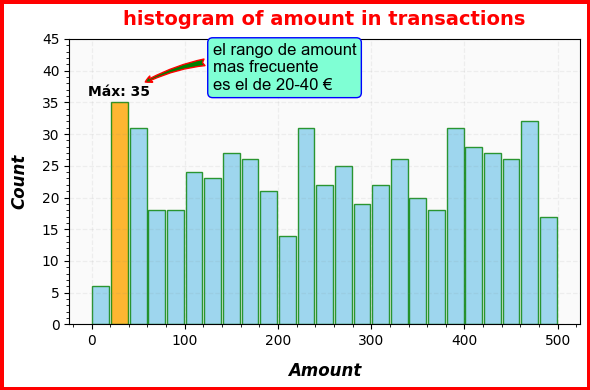

In [35]:
# Codigo Grafico

funct_figure('histogram of amount in transactions')
funct_grid()
funct_ejes_XY('Amount','Count')
plt.ylim(0,45) 
            
bins= np.arange(0,501,20)       
counts, bin_edges, patches = plt.hist(df_transactions['amount'], bins=bins, histtype='bar', rwidth=0.9, color='skyblue', alpha=0.8, edgecolor='green', linewidth=1)                               

max_idx = np.argmax(counts)
patches[max_idx].set_facecolor('orange')
bin_center = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2
plt.text(bin_center, counts[max_idx] + 1, f'Máx: {int(counts[max_idx])}', ha='center', fontsize=10, fontweight='bold', color='black')

x = (bin_edges[max_idx] + bin_edges[max_idx + 1]) / 2
y = counts[max_idx]
plt.annotate('el rango de amount\nmas frecuente\nes el de 20-40 €', xy=(x+25,y+3), xytext=(x+100, y+2 ), xycoords='data', textcoords='data', color = 'black', fontsize=12, fontweight='normal', fontname='Arial',                          
            arrowprops=dict(facecolor='green', edgecolor='red', linewidth=1, linestyle='-', arrowstyle='fancy', connectionstyle='arc3,rad=.2'),
            bbox=dict(boxstyle='round', facecolor='aquamarine', edgecolor='blue'))
plt.tight_layout()
plt.show()

## Nivel 1 Ejercicio 2
### 2 Variables numericas

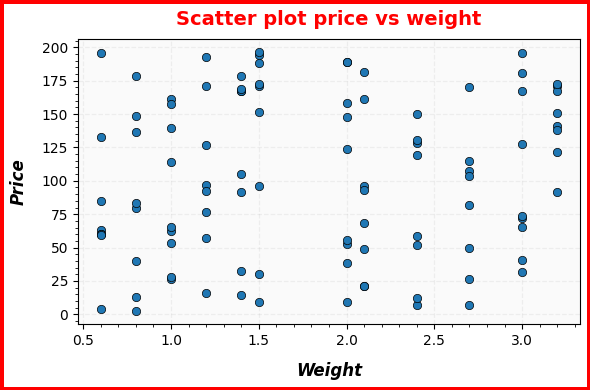

In [36]:
# Codigo Grafico

fig,ax = funct_figure('Scatter plot price vs weight')
funct_grid()
funct_ejes_XY('Weight','Price')

plt.scatter(df_products['weight'], df_products['price'], marker='o', edgecolors='black', linewidths=0.5)
plt.tight_layout()

plt.show()


## Nivel 1 Ejercicio 3
### 1 Variable Categorica

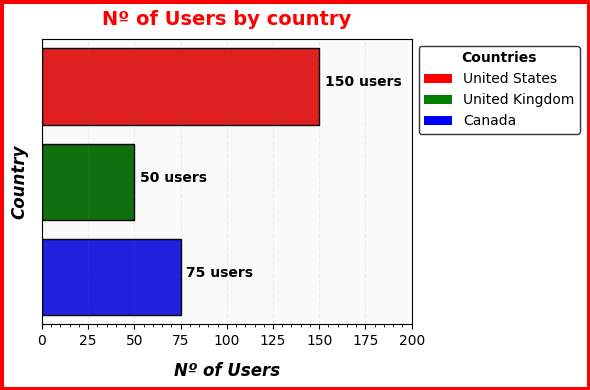

In [37]:
# Codigo Grafico

fig,ax = funct_figure('Nº of Users by country')
funct_grid()
funct_ejes_XY('Nº of Users','Country')
plt.xlim(0,200)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

palette = {'United States': 'red','United Kingdom': 'green','Canada': 'blue'}

sns.countplot(data=df_users, y="country", hue='country', palette=palette, edgecolor='black', legend=False)

legend_elements = [Patch(facecolor=color, label=label) for label, color in palette.items()]
legend = plt.legend(handles=legend_elements, title='Countries', edgecolor='black', fancybox=True, bbox_to_anchor=(1, 1))
legend.get_title().set_fontweight('bold')

[ax.text(patch.get_width()+3, patch.get_y() + patch.get_height()/2, f'{int(patch.get_width())} users', fontsize=10, fontweight='bold') for patch in ax.patches]
plt.tight_layout()

plt.show()

## Nivel 1 Ejercicio 4
### 1 Variable categorica 1 Variable numerica    

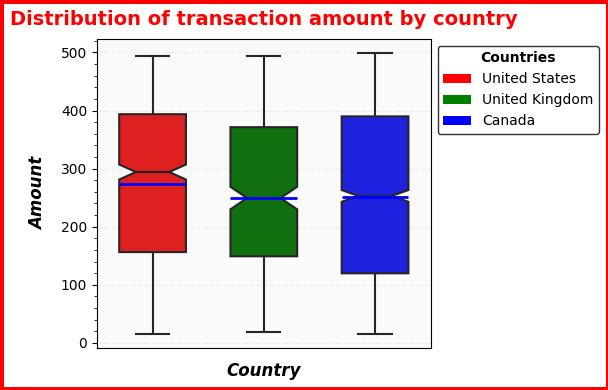

In [38]:
# Codigo grafico

fig,ax = funct_figure('Distribution of transaction amount by country')
funct_grid()
funct_ejes_XY('Country','Amount')

palette = {'United States': 'red','United Kingdom': 'green','Canada': 'blue'}
mean_line_props = {'linestyle': '-', 'color': 'blue', 'linewidth': 2}

plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

legend_elements = [Patch(facecolor=color, label=label) for label, color in palette.items()]
legend = plt.legend(handles=legend_elements, title='Countries', edgecolor='black', fancybox=True, bbox_to_anchor=(1, 1))
legend.get_title().set_fontweight('bold')

sns.boxplot(data=df_var_num_country, x="country", y="amount", hue="country", palette=palette, linewidth=1.5, width=0.6, notch=True, showmeans=True, meanline=True, meanprops=mean_line_props)
plt.tight_layout()

plt.show()


## Nivel 1 Ejercicio 5
### 2 Variables categoricas

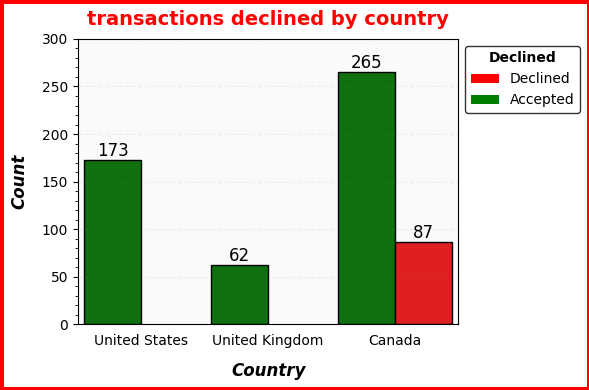

In [39]:
# Codigo Grafico

fig,ax = funct_figure('transactions declined by country')
funct_grid()
funct_ejes_XY('Country','Count')

plt.ylim(0,300)
plt.tick_params(axis='x', which='both', bottom=False) 

palette={1:'red',0:'green'}
sns.countplot(data=df_trans_user, x="country", hue="declined", palette=palette, dodge=True, width=0.9, edgecolor='black')

legend_elements = [Patch(facecolor=color, label='Accepted' if label==0 else 'Declined') for label, color in palette.items()]
legend = plt.legend(handles=legend_elements, title='Declined', edgecolor='black', fancybox=True, bbox_to_anchor=(1, 1))
legend.get_title().set_fontweight('bold')

[ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), f'{int(patch.get_height())}', ha='center', va='bottom', fontsize=12) for patch in ax.patches if patch.get_height() > 0]
plt.tight_layout()

plt.show()

## Nivel 1 Ejercicio 6
### 3 Variables

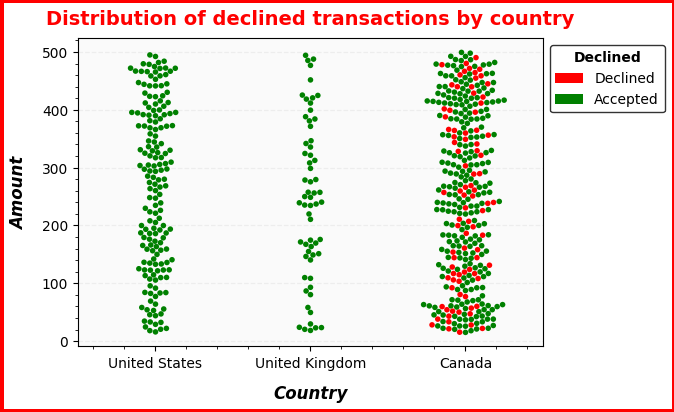

In [40]:
# Codigo Grafico

fig,ax = funct_figure('Distribution of declined transactions by country')
funct_grid()
funct_ejes_XY('Country','Amount')

palette = {1: 'red',0: 'green'}
sns.swarmplot(data=df_trans_user, x='country', y='amount', hue='declined', palette=palette, legend=False, s=4)

legend_elements = [Patch(facecolor=color, label='Accepted'if label==0 else 'Declined') for label, color in palette.items()]
legend = plt.legend(handles=legend_elements, title='Declined', edgecolor='black', fancybox=True, bbox_to_anchor=(1, 1))
legend.get_title().set_fontweight('bold')

plt.show()

## Nivel 1 Ejercicio 7
### Pairplot

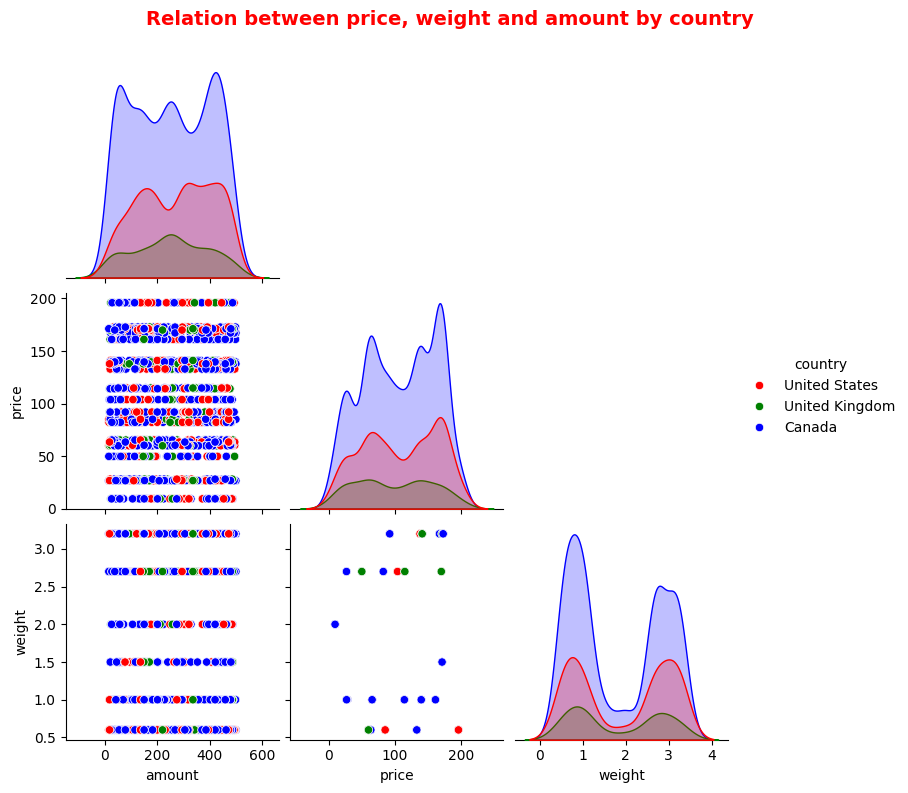

In [41]:
# Codigo Grafico
palette = {'United States': 'red','United Kingdom': 'green','Canada': 'blue'}
g=sns.pairplot(kind="scatter", diag_kind="kde", data=df_var_num_country, vars=["amount", "price", "weight"], hue="country", palette=palette,corner=True,)
g.fig.suptitle('Relation between price, weight and amount by country',y=1.05, family='serif', fontname=None, fontstyle='normal', fontsize=14, fontweight='bold', color='red')

plt.show()

## Nivel 2 Ejercicio 1
### Correlacion variables numericas

In [42]:
# Codigo 
corr = df_var_num_country[['amount', 'price', 'weight']].corr()
corr

,amount,price,weight
amount,1.000000,0.011335,-0.014904
price,0.011335,1.000000,0.194816
weight,-0.014904,0.194816,1.000000


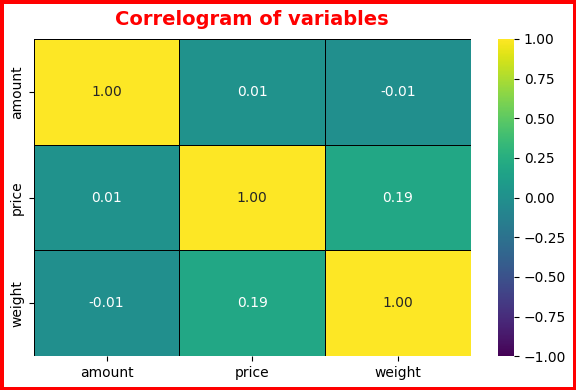

In [43]:
# Codigo Grafico
funct_figure('Correlogram of variables')
sns.heatmap(data=corr, vmin=-1, vmax=1, center=0, cmap="viridis", cbar=True, annot=True, fmt=".2f", annot_kws={"size": 10}, linewidths=0.5, linecolor="black",)
plt.tight_layout()
plt.show()


## Nivel 2 Ejercico 2
### Jointplot

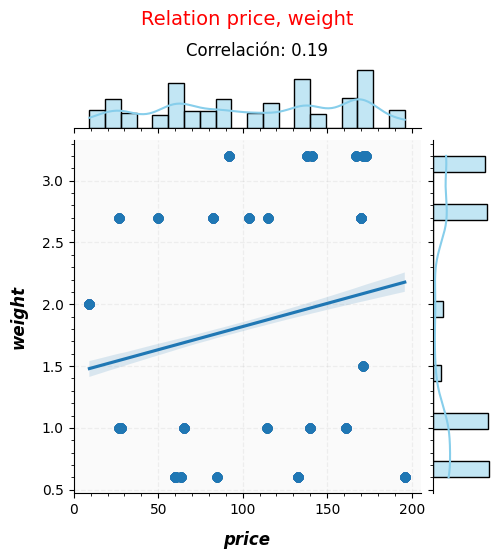

In [44]:
# Codigo Grafico
corr2 = df_var_num_country[['price', 'weight']].corr().loc['price', 'weight']

g=sns.jointplot(data=df_var_num_country, x='price', y='weight', kind='reg', height=5,marginal_kws={"bins": 20, "fill": True, "color": "skyblue"})

funct_ejes_XY('price','weight')
g.ax_joint.set_title("Relation price, weight", fontsize=14, color='red', pad=70,y=1.05)
plt.suptitle(f"Correlación: {corr2:.2f}", y=1.02)
g.ax_joint.set_facecolor('0.98')
plt.grid(which="major", axis="both", color="gray", linestyle="--", linewidth=0.9, alpha=0.1)
plt.show()


## Nivel 3 Ejercicio 1
### Violinplot + otro grafico

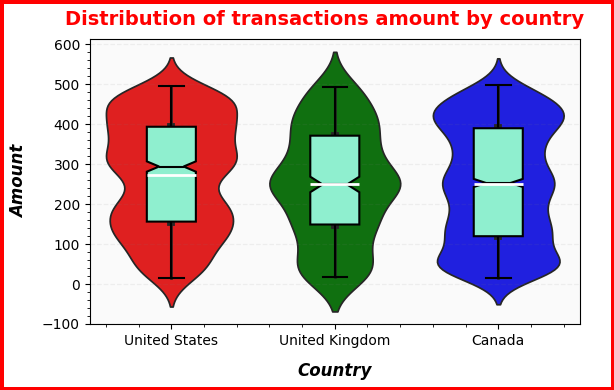

In [45]:
# Codigo Grafico
fig,ax = funct_figure('Distribution of transactions amount by country   ')
funct_grid()
funct_ejes_XY('Country','Amount')

palette = {'United States': 'red','United Kingdom': 'green','Canada': 'blue'}
sns.violinplot(data=df_var_num_country, x="country", y="amount", hue="country", hue_order=None, palette=palette,)
sns.boxplot(data=df_var_num_country, x="country", y="amount", color='aquamarine', linewidth=1.5, linecolor='black', width=0.3, notch=True, showmeans=True, meanline=True, meanprops={"color": "white", "linewidth": 2, "linestyle": "-"},)

plt.tight_layout()
plt.show()


## Nivel 3 Ejercicio 2
### FacetGrid

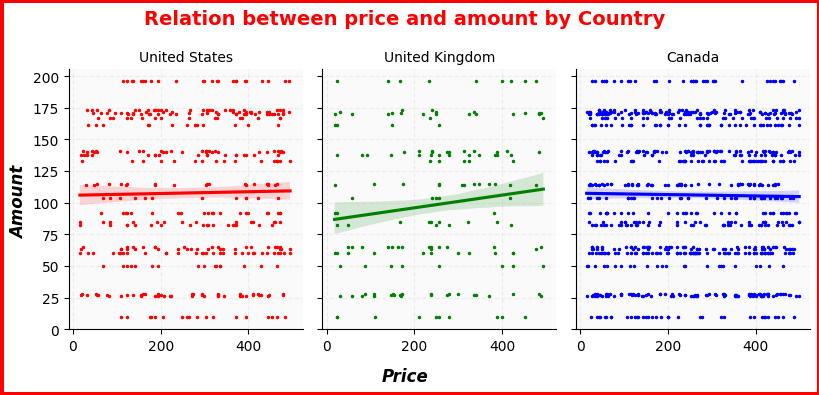

In [46]:
# Codigo Grafico
palette = {'United States': 'red','United Kingdom': 'green','Canada': 'blue'}
g = sns.FacetGrid(data=df_var_num_country, col="country", hue='country', palette=palette, despine=True, height=4, aspect=0.7,)       
g.map(sns.regplot, "amount", "price",scatter_kws={"s":2})

g.set_titles("{col_name}")
g.fig.patch.set_edgecolor('red')
g.fig.patch.set_linewidth(5)   
g.fig.suptitle('Relation between price and amount by Country', family='serif', fontname=None, fontstyle='normal', fontsize=14, fontweight='bold', color='red')

g.set(xlabel=None, ylabel=None)
g.fig.supxlabel('Price', y=0.04, fontsize=12, color='black', fontweight='bold', fontstyle='italic',)
g.fig.supylabel('Amount', x=0.03, fontsize=12, color='black', fontweight='bold', fontstyle='italic',)
     
for ax in g.axes.flat:
    ax.set_facecolor('0.98') 
    ax.grid(which="major", axis="both", color="gray", linestyle="--", linewidth=0.9, alpha=0.1)

plt.tight_layout()
plt.show()
